## Test Adult dataset
- Document of dataset: 
    + https://fairlearn.org/main/user_guide/datasets/acs_income.html#dataset-description
    + https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_adult.html
    + https://archive.ics.uci.edu/dataset/2/adult


In [47]:
# Custom imports
# import my_helper # my helper functions
from TabResNet import TabResNet  # Import from existing script

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd
import shap

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [51]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
# X_display, y_display = shap.datasets.adult(display=True)

# Load the dataset which has been label-encoded
X, y = shap.datasets.adult()

In [52]:
y_df = pd.DataFrame(y)

In [53]:
print(y_df.value_counts(normalize=True))

0    
False    0.75919
True     0.24081
Name: proportion, dtype: float64


## Data Preprocessing

### Label Encoding
Already done by SHAP - only need to drop attributes column "Sex"

In [48]:
X_le = X.drop(columns=["Sex"])

### Data Splitting & Formatting

In [54]:
random_state = 7
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_le, y, X["Sex"], test_size=0.2, random_state=random_state
)

In [55]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'Sex': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('Sex')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by sex group (as percentage):")
print((distribution * 100).round(2))


Class distribution by sex group (as percentage):
Label  False  True 
Sex                
0      88.99  11.01
1      69.54  30.46


In [56]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of A_train: ", A_train.shape)
print("Shape of A_test: ", A_test.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (26048, 11)
Shape of y_train:  (26048,)
Shape of A_train:  (26048,)
Shape of A_test:  (6513,)
Shape of X_test:  (6513, 11)
Shape of y_test:  (6513,)


In [57]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 


## Train

### XGB

In [58]:
from xgboost import XGBClassifier
# Train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=random_state
)

In [59]:
xgb_model.fit(X_train_np, y_train_np)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test_np)
xgb_accuracy = accuracy_score(y_test_np, xgb_preds)
print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")

XGBoost Test Accuracy: 0.8670


### MLP

In [60]:
from sklearn.neural_network import MLPClassifier

# Train MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=100,
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=400,
    random_state=random_state,
    early_stopping=True,
    n_iter_no_change=20
)

In [61]:

mlp_model.fit(X_train_np, y_train_np)

# Predict and evaluate
mlp_preds = mlp_model.predict(X_test_np)
mlp_accuracy = accuracy_score(y_test_np, mlp_preds)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")

MLP Test Accuracy: 0.8366


### TabResNet

In [62]:
# Instantiate model
model = TabResNet(
    d_in=X_test.shape[1], # Match input features
    d_out=2,
    n_blocks=2,
    d_block=32,
    d_hidden=64,
    dropout1=0.2,
    dropout2=0.05
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 400

In [63]:

for epoch in range(num_epochs):
    model.train()
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [100/400], Loss: 0.4915
Epoch [200/400], Loss: 0.3714
Epoch [300/400], Loss: 0.3315
Epoch [400/400], Loss: 0.3256


In [64]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8474


## Results

### Predicted positive counts by group (Income):

In [75]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'Sex': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('Sex')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by Sex group (as percentage) - Income Dataset:")
print((distribution * 100).round(2))

Class distribution by Sex group (as percentage) - Income Dataset:
Label  False  True 
Sex                
0      88.99  11.01
1      69.54  30.46


Imbalance Assessment

ACSIncome:

Sex 0 (likely female): 11.01% positive, Sex 1 (likely male): 30.46% positive.

Huge class imbalance (over 19 percentage points) between groups — clear structural disparity.

Despite this, models like TabResNet managed relatively good fairness (0.9191), suggesting it was better at mitigating inherent bias.

In [72]:
print("Predicted positive counts by group of Model XGB:")
print(pd.Series(xgb_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model XGB:
Sex
0     131
1    1037
dtype: int64


In [73]:
print("Predicted positive counts by group of Model MLP:")
print(pd.Series(mlp_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model MLP:
Sex
0     192
1    1020
dtype: int64


In [74]:
print("Predicted positive counts by group of Model TabResNet:")
print(pd.Series(preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model TabResNet:
Sex
0     172
1    1030
dtype: int64


### XGB

In [65]:
print("Predicted positive counts by group:")
print(pd.Series(xgb_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group:
Sex
0     131
1    1037
dtype: int64


array([[<Axes: title={'center': 'Accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Count'}, xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

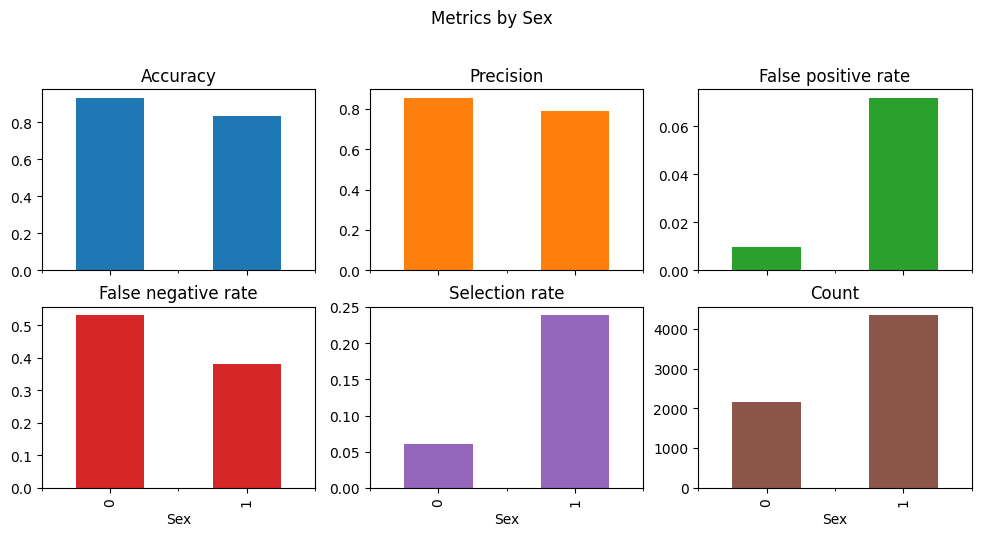

In [66]:
# Plot metrics using MetricFrame
xgb_metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

xgb_metric_frame = MetricFrame(
    metrics=xgb_metrics, y_true=y_test_np, y_pred=xgb_preds, sensitive_features=A_test
)

# Plotting
xgb_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [67]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
xgb_accuracy_values = xgb_metric_frame.by_group["Accuracy"]
xgb_acc_diff = xgb_accuracy_values.max() - xgb_accuracy_values.min()
print(f"Accuracy difference: {xgb_acc_diff:.4f}")

# Precision difference
xgb_precision_values = xgb_metric_frame.by_group["Precision"]
xgb_prec_diff = xgb_precision_values.max() - xgb_precision_values.min()
print(f"Precision difference: {xgb_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
xgb_tpr_values = 1 - xgb_metric_frame.by_group["False negative rate"]
xgb_tpr_diff = xgb_tpr_values.max() - xgb_tpr_values.min() 
print(f"True positive rate difference: {xgb_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
xgb_fpr_values = xgb_metric_frame.by_group["False positive rate"]
xgb_fpr_diff = xgb_fpr_values.max() - xgb_fpr_values.min()
print(f"False positive rate difference: {xgb_fpr_diff:.4f}")

# Demographic parity (DemP) difference
xgb_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=xgb_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {xgb_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
xgb_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=xgb_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {xgb_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0985
Precision difference: 0.0642
True positive rate difference: 0.1512
False positive rate difference: 0.0620
Demographic parity difference: 0.1784
Equalized odds difference: 0.1512


### MLP

array([[<Axes: title={'center': 'Accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Count'}, xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

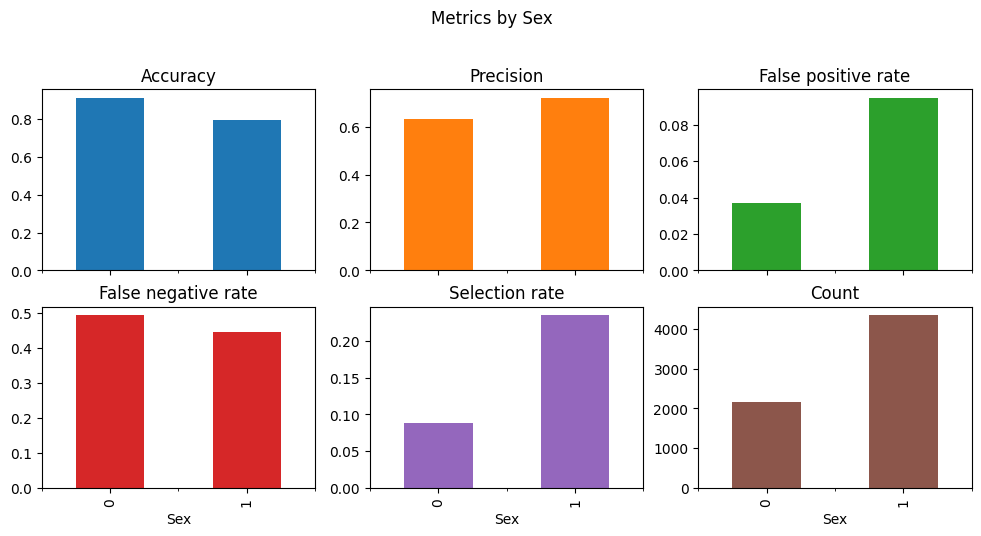

In [68]:
# Plot metrics using MetricFrame
mlp_metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

mlp_metric_frame = MetricFrame(
    metrics=mlp_metrics, y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test
)

# Plotting
mlp_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [69]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
mlp_accuracy_values = mlp_metric_frame.by_group["Accuracy"]
mlp_acc_diff = mlp_accuracy_values.max() - mlp_accuracy_values.min()
print(f"Accuracy difference: {mlp_acc_diff:.4f}")

# Precision difference
mlp_precision_values = mlp_metric_frame.by_group["Precision"]
mlp_prec_diff = mlp_precision_values.max() - mlp_precision_values.min()
print(f"Precision difference: {mlp_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_tpr_values = 1 - mlp_metric_frame.by_group["False negative rate"]
mlp_tpr_diff = mlp_tpr_values.max() - mlp_tpr_values.min() 
print(f"True positive rate difference: {mlp_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_fpr_values = mlp_metric_frame.by_group["False positive rate"]
mlp_fpr_diff = mlp_fpr_values.max() - mlp_fpr_values.min()
print(f"False positive rate difference: {mlp_fpr_diff:.4f}")

# Demographic parity (DemP) difference
mlp_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {mlp_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
mlp_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {mlp_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.1144
Precision difference: 0.0894
True positive rate difference: 0.0485
False positive rate difference: 0.0579
Demographic parity difference: 0.1464
Equalized odds difference: 0.0579


### TabResNet

array([[<Axes: title={'center': 'Accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Count'}, xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

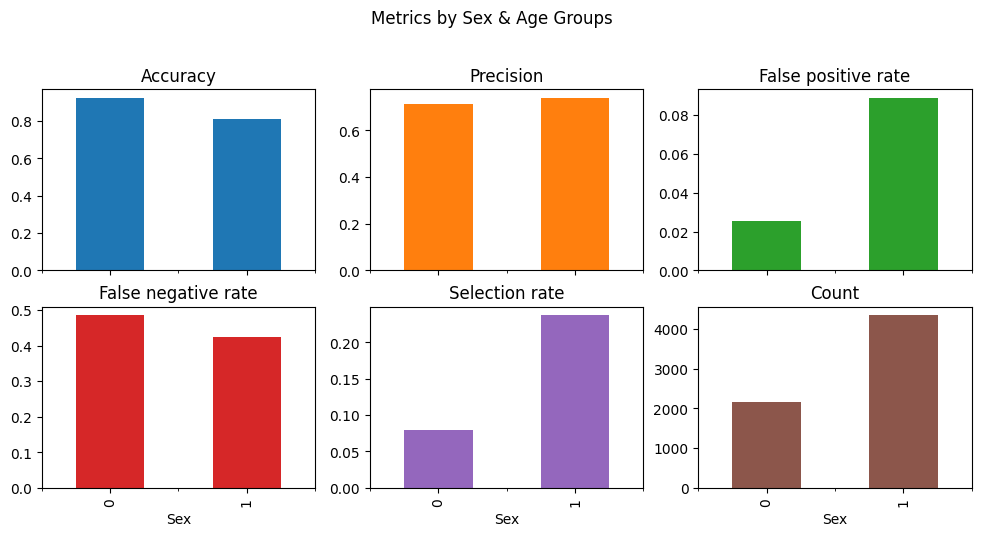

In [70]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex & Age Groups",
)

In [71]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.1148
Precision difference: 0.0247
True positive rate difference: 0.0613
False positive rate difference: 0.0634
Demographic parity difference: 0.1579
Equalized odds difference: 0.0634
